In [2]:
import os
import pandas as pd
import numpy as np
from scipy import stats
from tqdm import tqdm

In [2]:
filename = "Raw Data/touchevent.csv"

In [8]:
def decoupling_time(r):
    '''
    This will output in this format: 1970-08-22 19:25:00 
    '''
    s = str(r)
    year, month, day, hour, minute, second = s[:4], s[4:6], s[6:8], s[8:10], s[10:12], s[12:14]
    
    return '-'.join([year, month, day]) + ' ' + ':'.join([hour, minute, second])
#decoupling_time(20201117235750093)

In [17]:
final_data = pd.DataFrame()

five_million = 5*10**6
one_hundred = 10**2
c = 0
for chunk in tqdm(pd.read_csv(filename, chunksize=five_million)): 
    #deep copy 
    temp = pd.DataFrame(columns=['experimentid', 'userid'])
    temp = chunk[['experimentid', 'userid']]
    
    #turning now time from raw to machine readable ; #every minute has a specific count                                         
    shortened_times = pd.to_datetime(chunk['timestamp'].apply(
        decoupling_time), yearfirst=True).dt.floor('s')
    temp.insert(2, 'timestamp', shortened_times)
    #attenzione: il conteggio potrebbe essere meglio rappresentato
    # da una misura di massimo un numero di tocchi al secondo, oltre 
    #la quale si è outliers o c'è un errore nei dati; quando viene 
    # portato al minuto, la somma può essere divisa per secondi (60)
    
    #grouping 
    df_grouped = temp.groupby(['userid', 'experimentid', 'timestamp']).size()                                         
    df_grouped = df_grouped.reset_index(name='touches')
    
    #appending to a global df
    final_data = pd.concat([final_data, df_grouped], ignore_index=True) 
    c += 1  #safety loop before the kernel dies out
    if c == 100:
        break

12it [02:47, 14.64s/it]/tmp/ipykernel_6530/2316768393.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  shortened_times = pd.to_datetime(chunk['timestamp'].apply(
26it [06:05, 14.07s/it]


In [18]:
final_data.to_csv("reduced_file_by_second.csv")

In [19]:
final_data

,userid,experimentid,timestamp,touches
0,1,wenetItaly,2020-11-22 00:00:00,6
1,1,wenetItaly,2020-11-22 00:00:03,1
2,1,wenetItaly,2020-11-22 00:00:06,2
3,1,wenetItaly,2020-11-22 00:00:53,2
4,1,wenetItaly,2020-11-22 00:00:54,1
...,...,...,...,...
19859155,260,wenetItaly,2020-12-06 21:52:34,5
19859156,260,wenetItaly,2020-12-06 21:52:35,3
19859157,260,wenetItaly,2020-12-06 21:52:37,2
19859158,260,wenetItaly,2020-12-06 21:52:38,7


<Axes: ylabel='Frequency'>

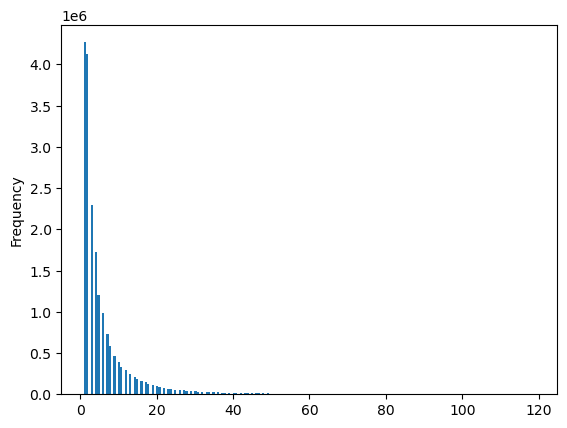

In [24]:
final_data[final_data.touches < 120].touches.plot.hist(bins=200)  

# Some methodological reflections. 
In order to get in second 40 touches per second you need to use all ten fingers on the screen. Four times. Which is just impossible. Consider this: 
- the fastest finger tapping rate was set by Japanese musician Kaoru Watanabe in 2014. He achieved a rate of 13.36 taps per second.
- Prabhshish Singh (at 13) accurately typed letters from A to Z on a mobile phone in just 3 seconds and 44 milliseconds, as confirmed on August 29, 2022, making it about 7.5 touches each second. 

I'd say not all users here must be world-record breakers, so for now at most _n_ touches per minute is a roof that doesn't exclude gamers, but further inspection with statistics will be done. 

We need to consider the **extreme touches**. Consider the median touches by second, and if it's an outlier it needs to be subsituted with a median. The median is a much more defensible measure because it has much less impact on the statistics than choosing any value, i.e. of the third quartile of the touch distribution. 

In [8]:
# in case I need to reload the data
final_data = pd.read_csv("reduced_file_by_second.csv")

KeyboardInterrupt: 

In [ ]:
temp = pd.DataFrame(columns=['experimentid', 'userid'])
temp = chunk[['experimentid', 'userid']]
   
#turning now time from raw to machine readable ; #every minute has a specific count                                         
shortened_times = pd.to_datetime(chunk['timestamp'].apply(decoupling_time), yearfirst=True).dt.floor('min')
temp.insert(2, 'timestamp', shortened_times)

#grouping 
df_grouped = temp.groupby(['userid', 'experimentid', 'timestamp']).size()                                         
df_grouped = df_grouped.reset_index(name='touches')    

Outliers belong to: 128 out of 201 of the users
Outliers are 355933 out of 19859160 . So: 1.79%


<Axes: >

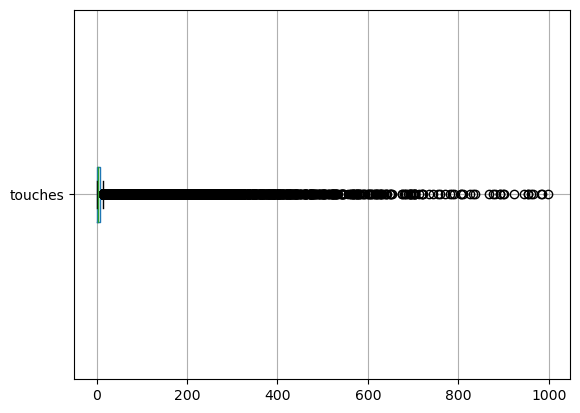

In [4]:
z = np.abs(stats.zscore(final_data['touches']))
threshold = 3  #this is the typical chosen score for outliers
outliers = final_data[z > threshold]
#print("User IDs with outlier observations:\n", np.sort(outliers.userid.unique()))
print("Outliers belong to:",outliers.userid.unique().shape[0], "out of", final_data.userid.unique().shape[0], 'of the users')
print("Outliers are", outliers.shape[0], "out of", final_data.shape[0], ". So:",  str(round(outliers.shape[0]/ final_data.shape[0]*100, 2))+'%')
final_data.boxplot(return_type='axes', column ="touches", vert=False)
# It seems like anything above 200 is considerable as an outlier. 

This will be the trick: each observation that is an outlier will be denoted as NaN, then the function .fillna() will come in handy.

In [32]:
median = final_data['touches'].median()
std = final_data['touches'].std()
outliers = (final_data['touches'] - median).abs() > std
final_data.touches[outliers] = np.nan

final_data['touches'].fillna(median, inplace=True)

In [7]:
final_data.boxplot(return_type='axes', column ="touches", vert=False)

<Axes: >

In [6]:
final_data

,Unnamed: 0,userid,experimentid,timestamp,touches
0,0,1,wenetItaly,2020-11-22 00:00:00,6
1,1,1,wenetItaly,2020-11-22 00:00:03,1
2,2,1,wenetItaly,2020-11-22 00:00:06,2
3,3,1,wenetItaly,2020-11-22 00:00:53,2
4,4,1,wenetItaly,2020-11-22 00:00:54,1
...,...,...,...,...,...
19859155,19859155,260,wenetItaly,2020-12-06 21:52:34,5
19859156,19859156,260,wenetItaly,2020-12-06 21:52:35,3
19859157,19859157,260,wenetItaly,2020-12-06 21:52:37,2
19859158,19859158,260,wenetItaly,2020-12-06 21:52:38,7
